In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates

# validation modules
import experiment
import metrics

In [2]:
name = 'filepaths_test'
cluster = 'laptop'
exp = experiment.experiment_from_dir(name, cluster)


preds = pd.read_csv('results/{n}_preds.csv'.format(n=name))
results_df = pd.read_csv('results/{n}.csv'.format(n=name), index_col='measurement_start_utc')
results_df.index = pd.to_datetime(results_df.index)

/usr/local/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


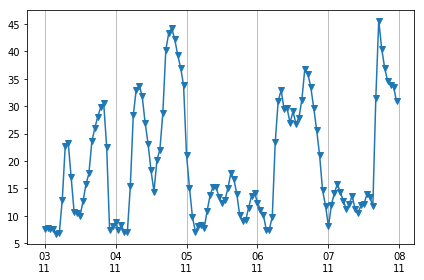

In [3]:
fig, ax = plt.subplots()
ax.plot_date(results_df.index, results_df.mae, 'v-')
# ax.plot_date(results_df.index, results_df.mse, 'v-')
# ax.plot_date(results_df.index, results_df.r2, 'v-')
# ax.xaxis.set_major_locator(dates.DayLocator())
#                            dates.WeekdayLocator(byweekday=(1),
#                                                 interval=1))
# ax.xaxis.set_minor_formatter(dates.DateFormatter('%d'))
ax.xaxis.grid(True, which="major")

ax.xaxis.set_major_locator(dates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%d\n%m'))
plt.tight_layout()
plt.show()
# results_df.r2.plot()


In [4]:
preds['measurement_start_utc'] = pd.to_datetime(preds['measurement_start_utc'])
gb = preds.groupby('point_id')
print(preds.columns)

Index(['Unnamed: 0', 'measurement_start_utc', 'point_id', 'source', 'location',
       'lat', 'lon', 'fit_start_time', 'predict_mean', 'predict_var', 'NO2'],
      dtype='object')


In [5]:
def plot_pretty_timeseries(time, series, ax, sigmas=None):
    ax.plot_date(time, series, ',', linestyle='-')
    ax.xaxis.grid(True, which="major")
    ax.xaxis.set_major_locator(dates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(dates.DateFormatter('%d\n%m'))
    
    if not sigmas is None:
        factor = 2
        y_min = series - factor*np.sqrt(sigmas)
        y_max = series + factor*np.sqrt(sigmas)
        ax.fill_between(time, y_min, y_max, color='orange', alpha=0.5)
        
        
    return ax

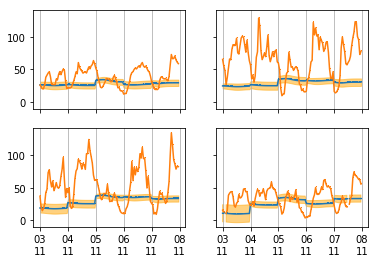

In [10]:
n = 2 # number of rows
c = 2 # number of columns
fig, axs = plt.subplots(n, c, sharex=True, sharey=True)
i = 0
j = 0
for point, row in gb:
    plot_pretty_timeseries(row['measurement_start_utc'], row['predict_mean'], axs[i, j], sigmas=row['predict_var'])
    plot_pretty_timeseries(row['measurement_start_utc'], row['NO2'], axs[i, j])
    i += j % c
    j += 1
    j = j % c
    if i == n:
        break